# Deep Knowledge Tracing using RNN (LSTM) model

Dataset: Assistments 2017

# Data Layer

Import Dataset from Drive

In [7]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

assistments = pd.read_csv('/content/drive/MyDrive/DeepKT/assistments_2017.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-7-fc93e142744a>:6: DtypeWarning: Columns (76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  assistments = pd.read_csv('/content/drive/MyDrive/DeepKT/assistments_2017.csv')


**Assistments 2017**

We will use mainly 2 columns from the dataframe: Skill and Correctness, the other two columns will be for aiding preprocessing.

In [8]:
assistments[['studentId', 'skill', 'correct', 'action_num']].head(15000)

,studentId,skill,correct,action_num
0,8,properties-of-geometric-figures,0,9950
1,8,properties-of-geometric-figures,1,9951
2,8,sum-of-interior-angles-more-than-3-sides,0,9952
3,8,sum-of-interior-angles-more-than-3-sides,0,9953
4,8,sum-of-interior-angles-more-than-3-sides,1,9954
...,...,...,...,...
14995,337,interpreting-numberline,1,269095
14996,337,interpreting-numberline,1,269096
14997,337,interpreting-numberline,0,269097
14998,337,inequality-solving,0,269098


# Preprocess

In [9]:
import pandas as pd
import numpy as np

from dataclasses import dataclass
from typing import Tuple, List, Dict

@dataclass
class SequenceConfig:
  seq_length: int
  sliding_window_step: int = 1
  max_students: int = 100

class SequenceGenerator:
  def __init__(self, config: SequenceConfig, skill_to_id: Dict):
    self.config = config # Configuring the parameters for preprocessing
    self.skill_to_id = {} # Mapping skills to unique IDs

  def load_and_process(self, file) -> Tuple[pd.DataFrame, int]:
    # Load and preprocess data from Dataset
    data = file

    num_skills = data['skill'].nunique()

    data.sort_values(by=['studentId', 'action_num'])

    selected_students = data['studentId'].unique()[:self.config.max_students]
    data = data[data['studentId'].isin(selected_students)]

    self.skill_to_id = self.skill_map(data)

    return data, num_skills

  def skill_map(self, data: pd.DataFrame) -> Dict[str, int]:
    skill_to_id = {}

    for skill in data['skill'].unique():
      skill_to_id[skill] = len(skill_to_id)

    return skill_to_id

  def encode_interaction(self, skill: int, correctness: int) -> List[int]:
    # Encode skill and correctness as separate values in a list
    return [skill, correctness]

  def generate_label(self, num_skills: int, skill: int, correctness: int) -> List[int]:
    # Create labels to calculate BCE loss
    label = np.zeros(num_skills)
    label[skill] = correctness
    return label

  def prepare_student_sequences(self, student_data: pd.DataFrame, num_skills: int) -> Tuple[List, List]:
    # Prepare sequences for each student
    sequences = []
    labels = []

    print('Checkpoint', student_data['studentId'])

    if len(student_data) < self.config.seq_length:
      return sequences, labels

    for i in range(0, len(student_data) - self.config.seq_length, self.config.sliding_window_step):
      if i + self.config.seq_length > len(student_data):
        break

      window = student_data.iloc[i: i + self.config.seq_length]

      next_interaction = student_data.iloc[i + self.config.seq_length]

      encoded_sequence = [self.encode_interaction(self.skill_to_id[row['skill']], row['correct']) for _, row in window.iterrows()]

      sequences.append(encoded_sequence)

      labels.append(window['correct'].tolist())

    return sequences, labels

  def prepare_sequences(self, df: pd.DataFrame, num_skills: int) -> Tuple[List, List]:
    all_sequences = []
    all_labels = []

    for student_id in df['studentId'].unique():
      student_data = df[df['studentId'] == student_id]

      student_seq, student_lab = self.prepare_student_sequences(student_data, num_skills)

      all_sequences.extend(student_seq)
      all_labels.extend(student_lab)

    return all_sequences, all_labels

gen = SequenceGenerator(SequenceConfig(10, 5, 200), {})

df, num_skills = gen.load_and_process(assistments)

df.head(100)

seq, lab = gen.prepare_sequences(df, num_skills)


Checkpoint 0       8
1       8
2       8
3       8
4       8
       ..
1051    8
1052    8
1053    8
1054    8
1055    8
Name: studentId, Length: 1056, dtype: int64
Checkpoint 1056    35
1057    35
1058    35
1059    35
1060    35
        ..
2044    35
2045    35
2046    35
2047    35
2048    35
Name: studentId, Length: 993, dtype: int64
Checkpoint 2049    39
2050    39
2051    39
2052    39
2053    39
        ..
2462    39
2463    39
2464    39
2465    39
2466    39
Name: studentId, Length: 418, dtype: int64
Checkpoint 2467    64
2468    64
2469    64
2470    64
2471    64
        ..
3881    64
3882    64
3883    64
3884    64
3885    64
Name: studentId, Length: 1419, dtype: int64
Checkpoint 3886    77
3887    77
3888    77
3889    77
3890    77
        ..
4198    77
4199    77
4200    77
4201    77
4202    77
Name: studentId, Length: 317, dtype: int64
Checkpoint 4203    126
4204    126
4205    126
4206    126
4207    126
       ... 
4604    126
4605    126
4606    126
4607    126
460

# **Save and Load Functions**

In [13]:
import pickle
import json
import os

def save_preprocessed_data(sequences, labels, skill_to_id, config, save_dir='/content/drive/MyDrive/DeepKT/preprocessed_data'):
    """Save preprocessed data to Google Drive"""
    # Mount Google Drive if not already mounted
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    os.makedirs(save_dir, exist_ok=True)

    # Save sequences and labels
    np.save(os.path.join(save_dir, 'sequences_10_s5.npy'), np.array(sequences))
    np.save(os.path.join(save_dir, 'labels_10_s5.npy'), np.array(labels))

    # Save skill mapping and configuration
    metadata = {
        'skill_to_id': skill_to_id,
        'config': {
            'seq_length': config.seq_length,
            'sliding_window_step': config.sliding_window_step,
            'num_students': config.max_students
        },
        'dataset_stats': {
            'num_sequences': len(sequences),
            'sequence_length': len(sequences[0]) if sequences else 0,
            'num_skills': len(skill_to_id)
        }
    }

    with open(os.path.join(save_dir, 'metadata_10_s5.json'), 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"Data saved successfully to {save_dir}")
    print("Files saved:")
    print(f"- sequences_10_s5.npy: {os.path.getsize(os.path.join(save_dir, 'sequences_10_s5.npy'))/1024/1024:.2f} MB")
    print(f"- labels_10_s5.npy: {os.path.getsize(os.path.join(save_dir, 'labels_10_s5.npy'))/1024/1024:.2f} MB")
    print(f"- metadata_10_s5.json: {os.path.getsize(os.path.join(save_dir, 'metadata_10_s5.json'))/1024:.2f} KB")

# # Save Preprocessed Data:
save_preprocessed_data(seq, lab, gen.skill_to_id, gen.config)

Data saved successfully to /content/drive/MyDrive/DeepKT/preprocessed_data
Files saved:
- sequences_10_s5.npy: 4.83 MB
- labels_10_s5.npy: 2.41 MB
- metadata_10_s5.json: 2.90 KB


# **In case already preprocessed, load initial packages and start here**

In [14]:
import pickle
import json
import os
from google.colab import drive
import numpy as np

def load_preprocessed_data(load_dir='/content/drive/MyDrive/DeepKT/preprocessed_data'):
    """Load preprocessed data from Google Drive"""
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    # Load sequences and labels
    sequences = np.load(os.path.join(load_dir, 'sequences_10_2.npy'))
    labels = np.load(os.path.join(load_dir, 'labels_10_2.npy'))

    # Load metadata
    with open(os.path.join(load_dir, 'metadata_10_2.json'), 'r') as f:
        metadata = json.load(f)

    print("Data loaded successfully")
    print(f"Loaded {metadata['dataset_stats']['num_sequences']} sequences")
    print(f"Sequence length: {metadata['dataset_stats']['sequence_length']}")
    print(f"Number of skills: {metadata['dataset_stats']['num_skills']}")

    return sequences, labels, metadata

# Load in preprocessed data
sequences, labels, metadata = load_preprocessed_data()

print(sequences[:50])
print(labels[:50])

Data loaded successfully
Loaded 81387 sequences
Sequence length: 10
Number of skills: 89
[[[ 0  0]
  [ 0  1]
  [ 1  0]
  [ 1  0]
  [ 1  1]
  [ 1  0]
  [ 1  1]
  [ 2  0]
  [ 3  0]
  [ 3  0]]

 [[ 0  1]
  [ 1  0]
  [ 1  0]
  [ 1  1]
  [ 1  0]
  [ 1  1]
  [ 2  0]
  [ 3  0]
  [ 3  0]
  [ 3  1]]

 [[ 1  0]
  [ 1  0]
  [ 1  1]
  [ 1  0]
  [ 1  1]
  [ 2  0]
  [ 3  0]
  [ 3  0]
  [ 3  1]
  [ 3  1]]

 [[ 1  0]
  [ 1  1]
  [ 1  0]
  [ 1  1]
  [ 2  0]
  [ 3  0]
  [ 3  0]
  [ 3  1]
  [ 3  1]
  [ 2  0]]

 [[ 1  1]
  [ 1  0]
  [ 1  1]
  [ 2  0]
  [ 3  0]
  [ 3  0]
  [ 3  1]
  [ 3  1]
  [ 2  0]
  [ 2  1]]

 [[ 1  0]
  [ 1  1]
  [ 2  0]
  [ 3  0]
  [ 3  0]
  [ 3  1]
  [ 3  1]
  [ 2  0]
  [ 2  1]
  [ 2  0]]

 [[ 1  1]
  [ 2  0]
  [ 3  0]
  [ 3  0]
  [ 3  1]
  [ 3  1]
  [ 2  0]
  [ 2  1]
  [ 2  0]
  [ 2  1]]

 [[ 2  0]
  [ 3  0]
  [ 3  0]
  [ 3  1]
  [ 3  1]
  [ 2  0]
  [ 2  1]
  [ 2  0]
  [ 2  1]
  [ 4  1]]

 [[ 3  0]
  [ 3  0]
  [ 3  1]
  [ 3  1]
  [ 2  0]
  [ 2  1]
  [ 2  0]
  [ 2  1]
  [ 4  1]
  [ 5

# Data Transformation

In [2]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_data(sequences, labels, batch_size = 64, train_ratio = 0.9, val_ratio = 0.01):
  sequences = sequences.astype(np.int32)
  labels = labels.astype(np.float32)

  train_sequences, temp_sequences, train_labels, temp_labels = train_test_split(sequences, labels, train_size=train_ratio, random_state=42)

  val_ratio_adjusted = val_ratio / (1 - train_ratio)

  val_sequences, test_sequences, val_labels, test_labels = train_test_split(temp_sequences, temp_labels, train_size=val_ratio_adjusted, random_state=42)

  def create_dataset(sequences, labels, batch_size, training=False):
    dataset = tf.data.Dataset.from_tensor_slices((sequences, labels))

    if training:
      dataset = dataset.shuffle(len(sequences)) # Shuffle tensors

    dataset = dataset.batch(batch_size)

    if training:
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # Prefetch for optimum training

    return dataset

  train_dataset = create_dataset(train_sequences, train_labels, batch_size)
  val_dataset = create_dataset(val_sequences, val_labels, batch_size)
  test_dataset = create_dataset(test_sequences, test_labels, batch_size)

  return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = prepare_data(sequences, labels)

def inspect_dataset(dataset, name="Dataset"):
    """Helper function to inspect the prepared datasets"""
    for sequences, labels in dataset.take(1):
        print(f"\n{name} inspection:")
        print(f"Sequences shape: {sequences.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Sequences dtype: {sequences.dtype}")
        print(f"Labels dtype: {labels.dtype}")
        print("\nSample sequence (first in batch):")
        print("Encoded interactions:", sequences[0])
        print("Correctness labels:", labels[0])

inspect_dataset(train_dataset, "Training")
inspect_dataset(val_dataset, "Validation")
inspect_dataset(test_dataset, "Test")


Training inspection:
Sequences shape: (64, 10, 2)
Labels shape: (64, 10)
Sequences dtype: <dtype: 'int32'>
Labels dtype: <dtype: 'float32'>

Sample sequence (first in batch):
Encoded interactions: tf.Tensor(
[[53  1]
 [45  0]
 [33  0]
 [33  0]
 [33  0]
 [33  1]
 [69  0]
 [69  0]
 [69  0]
 [69  1]], shape=(10, 2), dtype=int32)
Correctness labels: tf.Tensor([1. 0. 0. 0. 0. 1. 0. 0. 0. 1.], shape=(10,), dtype=float32)

Validation inspection:
Sequences shape: (64, 10, 2)
Labels shape: (64, 10)
Sequences dtype: <dtype: 'int32'>
Labels dtype: <dtype: 'float32'>

Sample sequence (first in batch):
Encoded interactions: tf.Tensor(
[[25  1]
 [51  1]
 [35  0]
 [25  1]
 [25  1]
 [35  1]
 [10  1]
 [35  1]
 [11  0]
 [11  0]], shape=(10, 2), dtype=int32)
Correctness labels: tf.Tensor([1. 1. 0. 1. 1. 1. 1. 1. 0. 0.], shape=(10,), dtype=float32)

Test inspection:
Sequences shape: (64, 10, 2)
Labels shape: (64, 10)
Sequences dtype: <dtype: 'int32'>
Labels dtype: <dtype: 'float32'>

Sample sequence (fir

# LSTM Implementation

In [4]:
import tensorflow as tf
import time
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

class LSTMModel(tf.keras.Model):
    def __init__(self, num_skills, seq_len, embed_dim, lstm_units, mlp_units, dropout_rate=0.1):
        """
        Args:
          num_skills: Number of unique skills in the dataset.
          seq_len: The sequence length.
          embed_dim: Embedding dimension for skills and correctness combined.
          lstm_units: Number of units in the LSTM layer.
          mlp_units: A list with the number of units for each MLP Dense layer.
          dropout_rate: Dropout rate to use after Dense layers.
        """
        super(LSTMModel, self).__init__()
        self.seq_len = seq_len

        # Separate embeddings for skills and correctness
        self.skill_embedding = tf.keras.layers.Embedding(num_skills, embed_dim // 2)
        self.correctness_embedding = tf.keras.layers.Embedding(2, embed_dim // 2)  # 2 possible values: 0 or 1

        # Positional encoding
        self.pos_encoding = tf.keras.layers.Embedding(seq_len, embed_dim)

        # LSTM layer (set return_sequences=True to output a sequence)
        self.lstm_layer = tf.keras.layers.LSTM(lstm_units, return_sequences=True)

        # MLP layers
        self.mlp_layers = []
        for mlp_dim in mlp_units:
            self.mlp_layers.append(tf.keras.layers.Dense(mlp_dim, activation='relu'))
            self.mlp_layers.append(tf.keras.layers.Dropout(dropout_rate))

        # Final prediction layer (sigmoid activation for binary prediction)
        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        """
        Args:
          inputs: Tensor of shape (batch_size, seq_len, 2) where inputs[:,:,0] contains skill IDs
                 and inputs[:,:,1] contains correctness values.
          training: Boolean flag for dropout behavior.

        Returns:
          predictions: Tensor of shape (batch_size, seq_len) with probabilities.
        """
        batch_size = tf.shape(inputs)[0]

        # Split the inputs into skill IDs and correctness values
        skill_ids = tf.cast(inputs[:, :, 0], tf.int32)      # (batch_size, seq_len)
        correctness = tf.cast(inputs[:, :, 1], tf.int32)    # (batch_size, seq_len)

        # Create positional indices
        positions = tf.range(start=0, limit=self.seq_len, delta=1)
        positions = tf.expand_dims(positions, axis=0)       # Shape: (1, seq_len)
        positions = tf.tile(positions, [batch_size, 1])     # Shape: (batch_size, seq_len)

        # Get embeddings for skills and correctness
        skill_emb = self.skill_embedding(skill_ids)         # (batch_size, seq_len, embed_dim//2)
        correctness_emb = self.correctness_embedding(correctness)  # (batch_size, seq_len, embed_dim//2)

        # Concatenate skill and correctness embeddings
        x = tf.concat([skill_emb, correctness_emb], axis=-1)  # (batch_size, seq_len, embed_dim)

        # Add positional encoding
        pos_enc = self.pos_encoding(positions)              # (batch_size, seq_len, embed_dim)
        x = x + pos_enc

        # Process with LSTM
        x = self.lstm_layer(x)  # (batch_size, seq_len, lstm_units)

        # Pass through the MLP layers
        for layer in self.mlp_layers:
            if isinstance(layer, tf.keras.layers.Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)

        # Final prediction layer produces shape (batch_size, seq_len, 1)
        x = self.final_layer(x)
        # Remove last dimension so the output shape becomes (batch_size, seq_len)
        return tf.squeeze(x, -1)

# Training

In [5]:
# ===============================================
# Training, Evaluation, and Testing Code
# ===============================================

# ----- Custom Training Step -----
@tf.function
def train_step(model, optimizer, batch_sequences, batch_labels):
    """
    Performs one training step for a batch.

    Args:
      model: The LSTM model.
      optimizer: An instance of tf.keras.optimizers.
      batch_sequences: Tensor of shape (batch_size, seq_len, 2) where [:,:,0] contains skill IDs
                       and [:,:,1] contains correctness values.
      batch_labels: Tensor of shape (batch_size, seq_len) with ground truth labels.

    Returns:
      loss: The average loss for the batch.
    """
    with tf.GradientTape() as tape:
        # Forward pass: get predictions
        predictions = model(batch_sequences, training=True)
        # In knowledge tracing, we predict the outcome of the *next* step:
        # Compare predictions at time t with labels at time t+1
        pred = predictions[:, :-1]
        target = tf.cast(batch_labels[:, 1:], tf.float32)
        loss = tf.keras.losses.binary_crossentropy(target, pred)
        loss = tf.reduce_mean(loss)

    # Backpropagation and optimizer step
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# ----- Evaluation Function -----
def evaluate_model(model, dataset):
    """
    Evaluates the model over an entire dataset.

    Args:
      model: The LSTM model.
      dataset: A tf.data.Dataset yielding (batch_sequences, batch_labels) where batch_sequences
               has shape (batch_size, seq_len, 2) and batch_labels has shape (batch_size, seq_len).

    Returns:
      auc: ROC-AUC computed over all predictions.
      accuracy: Binary accuracy computed over all predictions.
    """
    all_preds = []
    all_labels = []

    for batch_sequences, batch_labels in dataset:
        predictions = model(batch_sequences, training=False)
        # Shift predictions and labels so that prediction at time t is compared with label at time t+1
        pred = predictions[:, :-1]
        target = batch_labels[:, 1:]

        all_preds.append(pred)
        all_labels.append(target)

    # Concatenate outputs across batches
    all_preds = tf.concat(all_preds, axis=0)
    all_labels = tf.concat(all_labels, axis=0)

    # Flatten the tensors to compute scalar metrics
    all_preds_np = all_preds.numpy().flatten()
    all_labels_np = all_labels.numpy().flatten()

    try:
        auc = roc_auc_score(all_labels_np, all_preds_np)
    except Exception as e:
        print("Error computing AUC:", e)
        auc = 0.0

    y_pred_bin = (all_preds_np > 0.5).astype(int)
    accuracy = accuracy_score(all_labels_np, y_pred_bin)

    return auc, accuracy

# ----- Complete Training Loop -----
def train_model(model, train_dataset, val_dataset, test_dataset, epochs=50, patience=10, learning_rate=0.001):
    """
    Trains the model using a custom training loop, printing metrics during training and evaluating on
    the training, validation, and test datasets after each epoch.

    Args:
      model: The LSTM model.
      train_dataset: tf.data.Dataset for training.
      val_dataset: tf.data.Dataset for validation.
      test_dataset: tf.data.Dataset for testing.
      epochs: Maximum number of epochs to train.
      patience: Number of epochs to wait for improvement before early stopping.
      learning_rate: Learning rate for the optimizer.

    Returns:
      model: The trained model (with the best weights restored).
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    best_test_auc = 0.0
    patience_counter = 0
    best_weights = None

    for epoch in range(epochs):
        start_time = time.time()
        train_loss_metric = tf.keras.metrics.Mean()
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Training loop over batches
        for batch_idx, (batch_sequences, batch_labels) in enumerate(train_dataset):
            loss = train_step(model, optimizer, batch_sequences, batch_labels)
            train_loss_metric.update_state(loss)

            if (batch_idx + 1) % 50 == 0:
                print(f"  Batch {batch_idx+1} - Loss: {loss:.4f}")

        epoch_loss = train_loss_metric.result().numpy()
        print(f"Epoch {epoch+1} - Average Training Loss: {epoch_loss:.4f}")

        # Evaluate on test dataset
        test_auc, test_accuracy = evaluate_model(model, test_dataset)
        print(f"  Test Metrics - AUC: {test_auc:.4f} | Accuracy: {test_accuracy:.4f}")

        # Early stopping check (based on test AUC)
        if test_auc > best_test_auc:
            best_test_auc = test_auc
            best_weights = model.get_weights()
            patience_counter = 0
            print("  New best model found!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("  Early stopping triggered!")
                break

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1} took {epoch_time:.2f}s")

    # Restore best model weights if available
    if best_weights is not None:
        model.set_weights(best_weights)
        print(f"\nTraining completed. Best Test AUC: {best_test_auc:.4f}")

    final_test_auc, final_test_accuracy = evaluate_model(model, test_dataset)
    print(f"\nFinal Test Metrics - AUC: {final_test_auc:.4f} | Accuracy: {final_test_accuracy:.4f}")
    return model

lstm_model = LSTMModel(
    num_skills=len(metadata['skill_to_id']),  # Now using num_skills instead of num_items
    seq_len=metadata['config']['seq_length'],
    embed_dim=64,
    lstm_units=128,
    mlp_units=[128, 64],
    dropout_rate=0.1
)

# Train the model (this will print metrics during training and after each epoch):
trained_lstm_model = train_model(
    model=lstm_model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=50,
    patience=10,
    learning_rate=0.001
)


Epoch 1/50
  Batch 50 - Loss: 0.6274
  Batch 100 - Loss: 0.5981
  Batch 150 - Loss: 0.5997
  Batch 200 - Loss: 0.6034
  Batch 250 - Loss: 0.5999
  Batch 300 - Loss: 0.6237
  Batch 350 - Loss: 0.6092
  Batch 400 - Loss: 0.6095
  Batch 450 - Loss: 0.6146
  Batch 500 - Loss: 0.6259
  Batch 550 - Loss: 0.6095
  Batch 600 - Loss: 0.5978
  Batch 650 - Loss: 0.5821
  Batch 700 - Loss: 0.6306
  Batch 750 - Loss: 0.5847
  Batch 800 - Loss: 0.5949
  Batch 850 - Loss: 0.5707
  Batch 900 - Loss: 0.6043
  Batch 950 - Loss: 0.6053
  Batch 1000 - Loss: 0.6206
  Batch 1050 - Loss: 0.5843
  Batch 1100 - Loss: 0.6105
Epoch 1 - Average Training Loss: 0.6064
  Test Metrics - AUC: 0.6661 | Accuracy: 0.6803
  New best model found!
Epoch 1 took 17.23s

Epoch 2/50
  Batch 50 - Loss: 0.6009
  Batch 100 - Loss: 0.5778
  Batch 150 - Loss: 0.5803
  Batch 200 - Loss: 0.5908
  Batch 250 - Loss: 0.5815
  Batch 300 - Loss: 0.6200
  Batch 350 - Loss: 0.5938
  Batch 400 - Loss: 0.5987
  Batch 450 - Loss: 0.6029
  Batc

# Save and Load Model

In [ ]:
import os
import tensorflow as tf

# ====================================================
# Save the LSTM model weights
# ====================================================
save_dir = "/content/drive/MyDrive/DeepKT/saved_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

lstm_model_save_path = os.path.join(save_dir, "seq30_trained_lstm_model.weights.h5")
trained_lstm_model.save_weights(lstm_model_save_path)
print(f"Model weights saved to {lstm_model_save_path}")

# ====================================================
# Load the LSTM model for evaluation & visualization
# ====================================================
# Recreate the LSTM model architecture with the same configuration.
loaded_lstm_model = LSTMModel(
    num_items=2 * len(metadata['skill_to_id']),
    seq_len=metadata['config']['seq_length'],
    embed_dim=64,
    lstm_units=128,
    mlp_units=[128, 64],
    dropout_rate=0.1
)

# Build the model by passing a dummy input.
dummy_input = tf.zeros((1, metadata['config']['seq_length']))
_ = loaded_lstm_model(dummy_input, training=False)

# Load the saved weights.
loaded_lstm_model.load_weights(lstm_model_save_path)
print(f"Model loaded from {lstm_model_save_path}")


Model weights saved to /content/drive/MyDrive/DeepKT/saved_models/seq30_trained_lstm_model.weights.h5
Model loaded from /content/drive/MyDrive/DeepKT/saved_models/seq30_trained_lstm_model.weights.h5


# Visualization

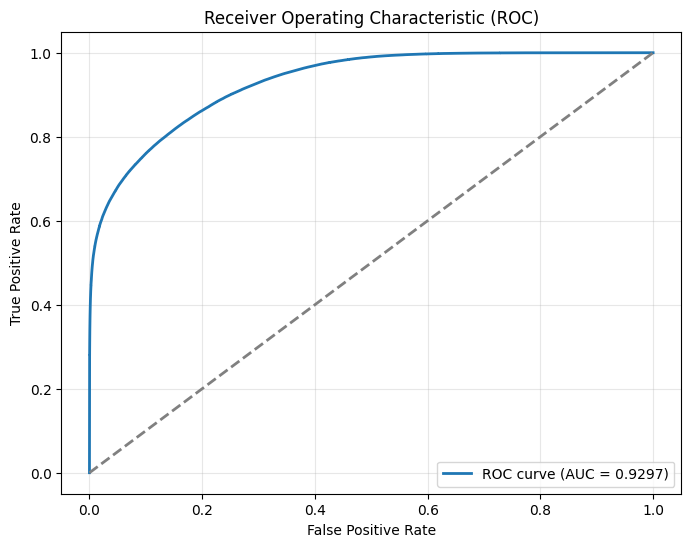

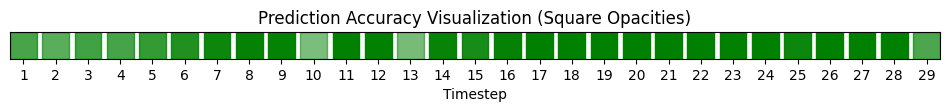

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, accuracy_score

def plot_roc_curve(model, dataset):
    """
    Generate and display the ROC curve for the given dataset using the LSTM-based model.

    For each batch, the predictions (with training=False) are computed and shifted so that
    prediction at time t is compared with the label at time t+1. The false positive and true
    positive rates are computed over all batches, and the ROC curve (with AUC) is plotted.
    """
    all_preds = []
    all_labels = []

    for batch_sequences, batch_labels in dataset:
        predictions = model(batch_sequences, training=False)
        # Remove the last timestep of predictions and the first timestep of labels
        pred = predictions[:, :-1]
        target = tf.cast(batch_labels[:, 1:], tf.float32)
        all_preds.append(pred)
        all_labels.append(target)

    # Concatenate all batches along the batch dimension.
    all_preds = tf.concat(all_preds, axis=0)
    all_labels = tf.concat(all_labels, axis=0)

    # Flatten to compute scalar metrics.
    y_scores = all_preds.numpy().flatten()
    y_true = all_labels.numpy().flatten()

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", lw=2)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


def visualize_sample_sequence_squares(model, dataset, sample_index=0, square_size=1, gap=0.2):
    """
    Visualize the predictive performance on a single sequence from the dataset as a sequence of squares.

    Each square’s opacity (green) indicates the prediction accuracy at that time step:
      - For a true label of 1, the score is the predicted probability.
      - For a true label of 0, the score is 1 minus the predicted probability.

    The predictions are shifted such that the prediction at time t is used to predict the outcome at t+1.

    Args:
      model: The trained LSTM-based model.
      dataset: A tf.data.Dataset yielding (batch_sequences, batch_labels).
      sample_index: The index of the sequence within the first batch to visualize.
      square_size: The side length of each square.
      gap: The gap between squares.
    """
    # Retrieve one batch from the dataset.
    for batch_sequences, batch_labels in dataset.take(1):
        break

    batch_sequences_np = batch_sequences.numpy()
    batch_labels_np = batch_labels.numpy()

    # Ensure sample_index is within the batch.
    if sample_index >= batch_sequences_np.shape[0]:
        sample_index = 0

    # Select the sample sequence and its corresponding labels.
    sample_sequence = batch_sequences_np[sample_index:sample_index+1]
    sample_labels = batch_labels_np[sample_index]

    # Obtain model predictions.
    predictions = model(sample_sequence, training=False).numpy()

    # Align predictions with labels: prediction at time t is for label at time t+1.
    pred_prob = predictions[0, :-1]
    true_labels = sample_labels[1:]

    # Compute per-timestep "accuracy" scores:
    # For a true label of 1, the score is the predicted probability;
    # For a true label of 0, the score is 1 minus the predicted probability.
    scores = np.where(true_labels == 1, pred_prob, 1 - pred_prob)
    n = len(scores)

    fig, ax = plt.subplots(figsize=(12, 3))

    # Draw squares for each time step with a gap.
    for i in range(n):
        x = i * (square_size + gap)
        alpha = scores[i]
        rect = plt.Rectangle((x, 0), square_size, square_size, color='green', alpha=alpha)
        ax.add_patch(rect)

    total_width = n * square_size + (n - 1) * gap
    ax.set_xlim(0, total_width)
    ax.set_ylim(0, square_size)
    ax.set_aspect('equal')

    # Set x-ticks at the center of each square.
    ax.set_xticks([i * (square_size + gap) + square_size/2 for i in range(n)])
    ax.set_xticklabels(np.arange(1, n+1))
    ax.set_yticks([])

    ax.set_xlabel("Timestep")
    ax.set_title("Prediction Accuracy Visualization (Square Opacities)")
    plt.show()


# Example usage:
# Replace 'trained_lstm_model' with your LSTM-based model variable and 'test_dataset' with your tf.data.Dataset.
plot_roc_curve(trained_lstm_model, test_dataset)
visualize_sample_sequence_squares(trained_lstm_model, test_dataset, sample_index=0)
